# Clasificación
Respondamos a la pregunta del capítulo anterior, marcando la columna "Species" con **1** en el caso de **Iris-setosa** y **0** de lo contrario.

Podemos utilizar una **condición en una columna** del DataFrame, la de "Species" en este caso,  el resultado será un objeto [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) de pandas con valores **verdero-falso** en las **filas** que cumplan la condición.

In [1]:
import pandas as pd

data = pd.read_csv("datasets/Iris.csv")

# mantenemos los datos en la variable original
df = data.drop(columns="Id")

is_setosa = df["Species"] == "Iris-setosa"
is_setosa

0       True
1       True
2       True
3       True
4       True
       ...  
145    False
146    False
147    False
148    False
149    False
Name: Species, Length: 150, dtype: bool

Ahora **reemplazamos la columna** por esta variable, convertida a **enteros** usando el método `astype`.   

Las primeras o últimas filas nos mostrarán sólo valores de 1, porque el dataset está ordenado según las especies y Setosa es la primera.  
Tomemos una **muestra** de cinco valores al azar con el método `sample` para verificar que existen valores enteros 😄. 

In [3]:
df['Species'] = is_setosa.astype(int)
df.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
104,6.5,3.0,5.8,2.2,0
100,6.3,3.3,6.0,2.5,0
125,7.2,3.2,6.0,1.8,0
5,5.4,3.9,1.7,0.4,1
39,5.1,3.4,1.5,0.2,1


## Clasificación Binaria
La prediciión se limita a **dos** valores, el término "binario" se debe a ello.  
Veamos la **relación** entre el **ancho del sépalo** con nuestro **target**:

Text(0, 0.5, '¿Es setosa?')

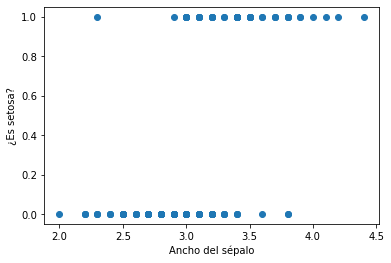

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df['SepalWidthCm'], df['Species'])
plt.xlabel("Ancho del sépalo")
plt.ylabel("¿Es setosa?")

Ajustar una **recta** no bastaría, deja muchos puntos fuera ☹.

Veamos si una **curva** lo hace mejor, podemos usar **Series** o **DataFrames** en nuestro modelo, pero deben estar en 2D porque sklearn espera que así sea. El mismo truco de seleccionar usando una **lista con una sola columna** funciona 😉

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(42)

# datos
X, y = df['SepalWidthCm'], df['Species']
X_train, X_test, y_train, y_test = train_test_split(X.values.reshape(-1, 1), y, test_size=0.2)

Ahora toca entrenar, **elige cualquier modelo** de los que vimos para **regresión lineal**.  
También debes **transformar** las features a **polinomiales**, te sugiero usar un **grado** mayor a 2

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# modelo
poly = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

Veamos los resultados, toma en cuenta que `X_train` es un DataFrame, por esto tiene sus propios métodos `min` y `max` 

Text(0, 0.5, '¿Es setosa?')

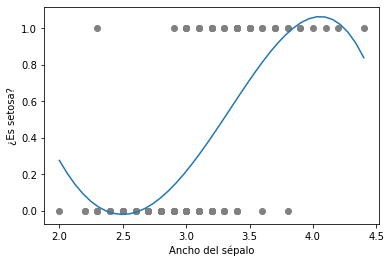

In [23]:
# gráfica
xpoints = np.linspace(X_train.min(), X_train.max(), num=40)
xpoints_poly = poly.transform(xpoints.reshape(-1, 1))
ypoints = model.predict(xpoints_poly)

plt.scatter(X_train, y_train, color='gray')
plt.plot(xpoints, ypoints)
plt.xlabel("Ancho del sépalo")
plt.ylabel("¿Es setosa?")

Por mucho que incrementemos el grado no llegaremos a una curva convincente, al menos no con un modelo lineal 🤔.

## Sigmoide
Exi**s**te una curva que encaja muy bien con este problema, tiene forma de **S** y va en un rango de 0 a 1, justo lo que necesitamos, aunquer **nunca llega exactamente a 0 o 1**, su fórmula es:

 $\sigma(x) = \dfrac{1}{1 + e^{-x}}$

Donde $\sigma$ es la letra *sigma*, $e$ es el [número e](https://es.wikipedia.org/wiki/N%C3%BAmero_e), y $x$ es un punto cualquiera, podría ser de nuestra **feature** o un rango de valores.  
Definamos esto último para graficarla 😉.

Text(0, 0.5, 'sigma(x)')

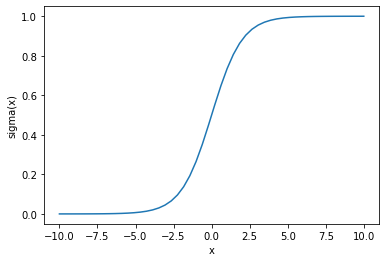

In [24]:
xpoints = np.linspace(-10, 10, num=50)

# np.exp(x) equivale a e^x
ypoints = 1 / (1 + np.exp(-xpoints))

plt.plot(xpoints, ypoints)
plt.xlabel('x')
plt.ylabel('sigma(x)')

Ahora tenemos una curva que bien podría ajustarse a los datos, si la utilizamos tenemos un **nuevo modelo** conocido como...

## Regresión Logística
Nuevo objetivo:  hallar la **sigmoide** que mejor se **ajuste** a los datos cambiando los ¿parámetros?

La sigmoide no tiene **parámetros** que podamos ajustar, por lo que **primero definimos una regresión lineal** guardando los resultados en una variable:

$z = X\theta$

Entonces, le aplicamos la **sigmoide**:  
$\hat{y} = \sigma(z)$

Esta idea será muy importante más adelante 😉. 

Por último, definiremos un **umbral**, pongamos 0.5. Si $\sigma(z)$ es **mayor al umbral**, la predicción será **1** y será **0 de lo contrario**.

De todo esto se encargará `LogisticRegressor` de sklearn, pero este modelo espera que `y` sea **1D** asi que convertiremos este **DataFrame** a un **array de numpy** y le aplicaremos `reshape` a una sola dimensión.

/home/pablo/ml/anaconda3/envs/zzml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Text(0, 0.5, '¿Es setosa?')

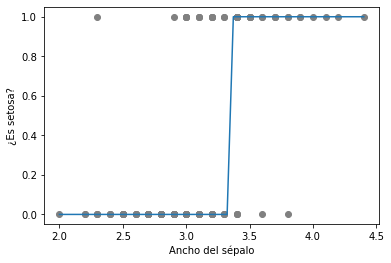

In [32]:
from sklearn.linear_model import LogisticRegression

model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train.values.reshape(-1, 1))

xpoints = np.linspace(X_train.min(), X_train.max(), num=50)
ypoints = model_logistic.predict(xpoints.reshape(-1, 1))

plt.scatter(X_train, y_train, color="gray")
plt.plot(xpoints, ypoints)
plt.xlabel("Ancho del sépalo")
plt.ylabel("¿Es setosa?")

Sección en construcción 👷

Muy bien, quizá demasiado bien... pero es porque sklearn retorna un resultado **entero** por defecto.

Por cierto, el nombre viene de la **logística** que maquinamos para lograr la clasificación binaria 😎  
$\cdots$

No, en realidad viene de la función [logit](https://es.wikipedia.org/wiki/Logit) que es la base para su **función de costo**:

$J(\theta) = -y\ log(\hat{y}) + (1-y)\ log(1 - \hat{y})$

Esta expresión encierra nuestras **dos** posibles **respuestas**, nota que tienen complementos en forma de $(1-y)$.

Si $y=0$ tenemos:  
$-0\ log(\hat{y}) - (1-0)\ log(1 - \hat{y})$  
$= -log(1 - \hat{y})$

Si $y=1$ tenemos:  
$\ -log(\hat{y})$

Grafiquemos ambas en un rango de 0 a 1, pero **no exactamente 0 o 1**

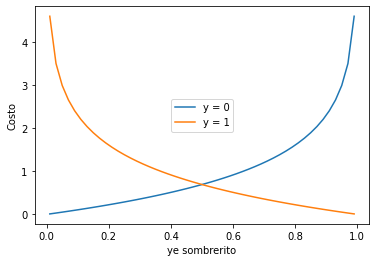

In [33]:
xpoints = np.linspace(0.01, 0.99, num=50)

plt.plot(xpoints, -np.log(1 - xpoints), label="y = 0")
plt.plot(xpoints, -np.log(xpoints), label="y = 1")
plt.xlabel("ye sombrerito")
plt.ylabel("Costo")

plt.legend(loc="center")

Para la línea **y = 0**, tenemos menor costo si nos **acercamos a 0**, pues tambien nos acercaríamos a la respuesta correcta.

Para el otro caso, tenemos la situación contraria siendo **menor** el costo **cerca a 1**.

Recuerda que **sólo una de las funciones** es utilizada, dependiendo del **valor de y**.

Nota que la función es más **empinada** cuanto **mayor** sea el **costo**, esto significa que **penaliza** más las respuestas **incorrectas**, además es **convexa** pues sólo tiene un mínimo 😃

## Respondiendo la pregunta
Para responder mejor, entrena el modelo con **todas** las features, **completa el código** 😃

In [ ]:
# todas las features
X = df.iloc[:, :-1]

y = df['___']

X_train, ___, y_train, ___ = train_test_split(X, y, test_size=0.2)

model = Lo___
model.fit(___, ___)

# ¿es setosa u otra cosa?
model.predict([[5.81, 3.05, 4.9, 2.11]])

## Evaluando
Como tenemos sólo dos posibles respuestas, desearemos ver cuántas veces **acertamos**, más bien, el **porcentaje de aciertos**.

Esto se conoce como **exactitud** y usando `accuracy_score` lo sabremos en un rango de 0 a 1, esta vez **sí** exactamente 0 o 1.

In [ ]:
from sklearn.metrics import accuracy_score

y_hat = model.predict(X_test)
accuracy_score(y_hat, y_test)

La exactitud es **engañosa**, no te fíes sólo de ella 😄 en especial en **datasets no balanceados**.

Para algunos datasets pueden ser difícil conseguir casos en la una **proporción similar**, un clásico ejemplo:  
Quieres detectar si hubo **fraude** en transacciones bancarias, pero la mayoría **no son fraudulentas** (o eso espero)

Este simple modelo puede **alcanzar gran exactitud**:

In [ ]:
class modelin():
    def predict(X):
        return [False] * len(X)

Supongamos que solo el **10%** de tu test set tiene **transacciones fraudulentas**, evaluemos a modelín:

In [ ]:
test_features = np.random.randn(10)
test_targets = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

pred_targets = modelin.predict(test_set)
accuracy_score(pred_targets, test_targets)

¡Genial!, modelín detecta el fraude con un **90%** de ...por eso digo que es **engañosa** ☹

Pero la idea base se mantiene saber la **cantidad de aciertos y fallas** entre la **predicción** del modelo y las **respuestas**, con esto podemos construir **cuatro casos**:

+ La respuesta es 1 el modelo predijo 1 😄
+ La respuesta era 1 el modelo predice 0 ☹
+ Respuesta real 0, modelo predice 0 😄
+ Respuesta 0, modelo predice 1 ☹

Un poco... **confuso**, ¿verdad?

### Matriz de Confusión
Podemos agrupar los casos en una matriz de dos filas y dos columnas de 0 y 1:

![conf](./img/7.5_confussion_matrix.png)

**Positivo** o **negativo** nos indicará la respuesta **predicha**, y será **verdadero** o **falso** si es o no **igual a la real**.  
Usaremos los términos en inglés, pero sólo con sus iniciales: *True Positive* será **TP**, *False Negative*, **FN**.

Las celdas de la matriz contienen la **cantidad de cada caso**, por esto la **suma** de todas las celdas resulta en el **total** de datos que usamos para calcularla.

Con la matriz podemos calcular dos métricas que se **compensan** entre sí.

### Precision
Cuya fórmula es:

$precision = \dfrac{TP}{TP + FP}$

Sólo toma en cuenta **positivos, reales y predichos**, para responder la pregunta:  
> De todos los positivos, ¿cuántos lo son realmente?  

Esto es util para reducir falsos positivos, mientras menos sean, más alta será la precision.  
En nuestro caso, un FP sería:
> El modelo predijo que sí hubo fraude, pero no lo hubo.

### Recall
Cuya fórmula es:

$recall = \dfrac{TP}{TP + FN}$

Y toma en cuenta la **fila** de **positivos reales** para preguntar:
> ¿Cuántos positivos fueron predichos correctamente?

Es util para minimizar un FN:
> El modelo predijo que no hubo fraude, pero sí lo hubo.

Como ambos se compensan, debemos elegir cuál **penalizar más** para reducirlo.  
> ¿Es peor dar una **falsa alarma** o **dejar pasar** un fraude?

Podemos calcular todo lo visto usando `confusion_matrix`, `precision_score` y `recall_score`

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

print(confusion_matrix(test_targets, pred_targets))

print("Precision:", precision_score(test_targets, pred_targets))
print("Recall:", recall_score(test_targets, pred_targets))

Tenemos una advertencia por la división entre 0, ¡no tenemos **ningún** positivo! y sólo mirando la matriz de confusión podemos intuir "algo anda mal".

Quizá alguna vez nos interese encontrar un **balance entre precision y recall**, podemos calcular esto usando `f1_score` cuya fórmula es:

$F1 = 2*\dfrac{precision*recall}{precision+recall}$

### Evalua el modelo
Te animo a que evalues nuestro **modelo de iris setosa**, comienza mirando la **matriz de confusión** 😄

In [ ]:
from sklearn.metrics import f1_score

y_hat = model.predict(X_test)

confusion_matrix(y_hat, )

# precision_score()
# recall_score()
# f1_score()

Como pudimos ver, la clasificación es un mundo un poco distinto, pero seguimos dentro del **aprendizaje supervisado** porque tenemos features y targets.

Y no acaba aquí, también podemos distinguir entre [varias clases](8_clasificacion_multiclase).